<a href="https://colab.research.google.com/github/geraldoferreira1963/Analise_Sentimento/blob/main/Analise_Sentimento_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

O objetivo do trabalho é utilizando um dataset (https://www.kaggle.com/datasets/deepakjoshi2k/yahoo-stock-prediction-by-news) predizer se ação de uma dada empresa - no final de dia de negociação - subirá ou descera (tomando como base o dia anterior).


Este algoritmo, juntamente com outros algoritmos ou metodologias, por exemplo Análise Gráfica, poderiam ser combinados a fim de se criar um ferramenta de suporte a operação de compra e venda de ativos em um único dia na bolsa de valores.


No treinamento do algoritmo foi utilizado o dataset https://www.kaggle.com/datasets/deepakjoshi2k/yahoo-stock-prediction-by-news, o qual possui as seguintes colunas :   

(i)     **ticker** : código da ação na Bolsa de Valores de New York
(ii)    **Date** : Data da notícia ou opinião
(iii)   **Category** : se é uma notícia, ou uma opinião de um analista.
(iv)    **title** : título da notícia, ou do artigo
(v)     **content** : conteúdo da notícia, ou do artigo
(vi)    **Open** : valor de abertura da ação
(vii)   **High** : valor de fechamento da ação
(viii)  **Low** : menor valor da ação no dia
(ix)    **Close** : valor de fechamento do preço da ação
(x)     **Adj cloe** : Ajusted Closing Price, ajuste no preço da ação decorrente de algum evento na base acionária da empresa
(xi)    **Volume** : volume de ações negociadas no dia
(xii) **label** : indicação se o preço da ação fechou com um valor maior que o preço **inicial** (1), ou fechou em um valor menor (0)





In [54]:
!pip install scikit-learn -q


import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string


from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import TextVectorization
from sklearn.preprocessing import LabelEncoder  # Import LabelEncoder

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from IPython import get_ipython
from IPython.display import display

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

As funções abaixo foram criadas.

(1) dataframe_analize : objetivo é realizar uma simples
(2) b

In [30]:
def analisar_dataframe (df, column_name='title'):  # Add column_name parameter with default 'title'
    """Analyzes a DataFrame and prints statistics about labels, content, and category.

    Args:
        df: The DataFrame to analyze.
        column_name: The column to use for content analysis ('title' or 'content').
    """

    # Count and print label occurrences
    label_counts = df['label'].value_counts()
    print("Número de Linhas com Label 0:", label_counts[0])
    print("Número de Linhas com Label 1:", label_counts[1])

    # Plot label distribution
    label_counts.plot(kind='bar', title='Distribuição dos Labels')
    plt.xlabel('Label')
    plt.ylabel('Contagem')
    plt.show()

    # Calculate and print content length statistics
    df['text_length'] = df[column_name].apply(len)  # Use column_name instead of 'title'
    print("Minimo comprimento do conteúdo:", df['text_length'].min())  # Use 'text_length'
    print("Máximo comprimento do conteúdo:", df['text_length'].max())  # Use 'text_length'

    # Calculate and print the number of unique words
    all_words = ' '.join(df[column_name]).lower().split()  # Use column_name instead of 'title'
    unique_words = set(all_words)
    print("Numero de palavras únicas:", len(unique_words))

    # Combined category-label plot
    plt.figure(figsize=(12, 6))
    sns.countplot(x='category', hue='label', data=df)
    plt.title('Distribuição das Categorias/Label')
    plt.xlabel('Categoria')
    plt.ylabel('Contagem')
    plt.xticks(rotation=45, ha='right')
    plt.show()
    return(len(unique_words),df['text_length'].min(),df['text_length'].max())

In [22]:
def criar_dataframe_balanceado(df, num_instances):
  """Creates a balanced DataFrame with a specified number of instances for each label.

  Args:
    df: The original DataFrame.
    num_instances: The desired number of instances for each label.

  Returns:
    A new DataFrame with balanced labels.
  """

  # Separate instances with label 0 and label 1
  label_0_df = df[df['label'] == 0]
  label_1_df = df[df['label'] == 1]

  # Sample the desired number of instances from each label
  balanced_label_0_df = label_0_df.sample(n=num_instances, random_state=42)  # Use random_state for reproducibility
  balanced_label_1_df = label_1_df.sample(n=num_instances, random_state=42)

  # Concatenate the balanced DataFrames
  balanced_df = pd.concat([balanced_label_0_df, balanced_label_1_df])

  return balanced_df

In [40]:
def preprocess_text(text, lemmatize=True):
    """Removes stop words, punctuation, and optionally performs lemmatization.

    Args:
        text: The input text string.
        lemmatize: A boolean indicating whether to perform lemmatization.

    Returns:
        The preprocessed text string.
    """

    # Tokenize the text
    tokens = nltk.word_tokenize(text.lower())

    # Remove punctuation
    tokens = [token for token in tokens if token not in string.punctuation]

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize if specified
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join the tokens back into a string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

In [7]:
# Corrected URL to download the raw Excel file from GitHub
url = 'https://raw.githubusercontent.com/geraldoferreira1963/Analise_Sentimento/main/carga_inicial_6.xlsx'

response = requests.get(url)

# Save the content to a file with .xlsx extension
with open('carga_inicial_6.xlsx', 'wb') as file:
    file.write(response.content)

# Read the Excel file, explicitly specifying the engine
df = pd.read_excel('carga_inicial_6.xlsx', engine='openpyxl') # Added engine parameter

# Display the first few rows of the DataFrame
df.head()

,Date,category,title,content,label
0,2020-01-27,opinion,Apple Set To Beat Q1 Earnings Estimates Tech ...,Technology giant Apple NASDAQ AAPL is set ...,0
1,2020-01-27,opinion,Tech Daily Intel Results Netflix Surge Appl...,The top stories in this digest are Intel s N...,0
2,2020-01-27,opinion,7 Monster Stock Market Predictions For The Wee...,S P 500 SPY \nThis week will be packed with e...,0
3,2020-01-27,opinion,Apple Earnings Preview 5G Launch Expanding S...,Reports Q1 2020 results on Tuesday Jan 28 ...,0
4,2020-01-27,opinion,Buy Surging Apple Microsoft Stock Before Qua...,On today s episode of Full Court Finance here ...,0


Visualização Inicial do Dataset

Número de Linhas com Label 0: 7135
Número de Linhas com Label 1: 8840


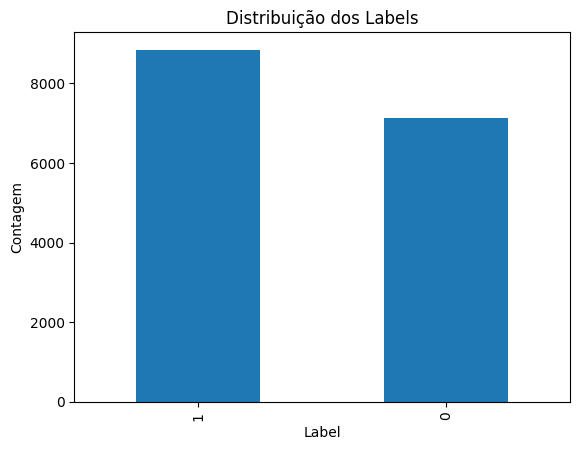

Minimo comprimento do conteúdo: 41
Máximo comprimento do conteúdo: 32765
Numero de palavras únicas: 85086


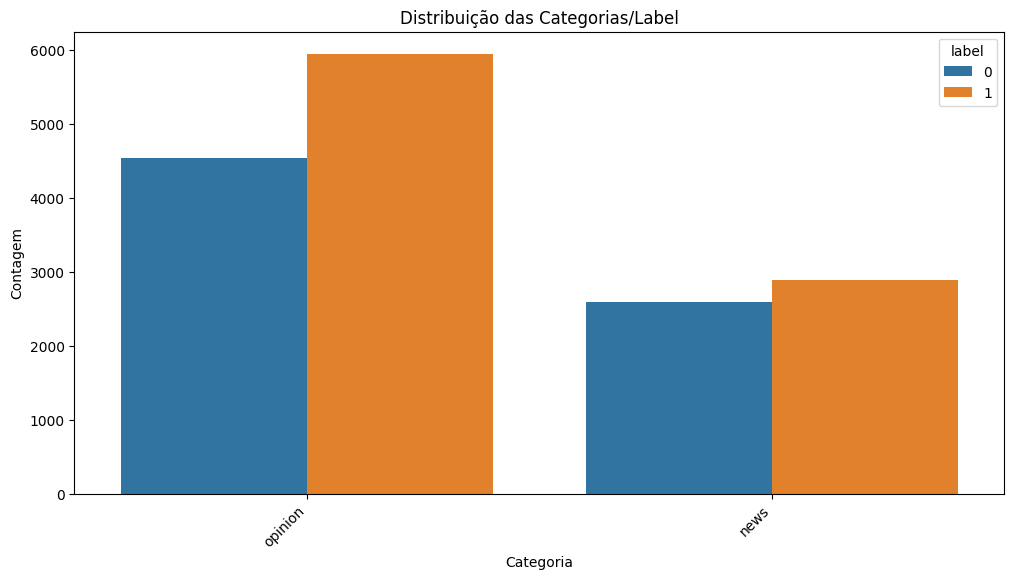

(85086, 41, 32765)

In [31]:

# Verificação Inicial do dataset
analisar_dataframe(df,column_name='content')  # Call the function to analyze your DataFrame


Ajuste Inicial

Número de Linhas com Label 0: 2000
Número de Linhas com Label 1: 2000


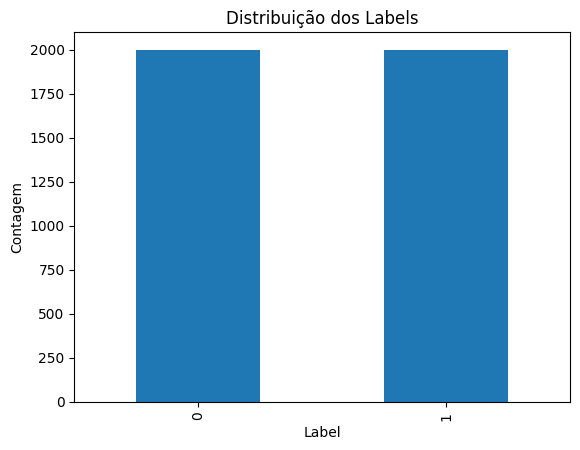

Minimo comprimento do conteúdo: 41
Máximo comprimento do conteúdo: 32765
Numero de palavras únicas: 43794


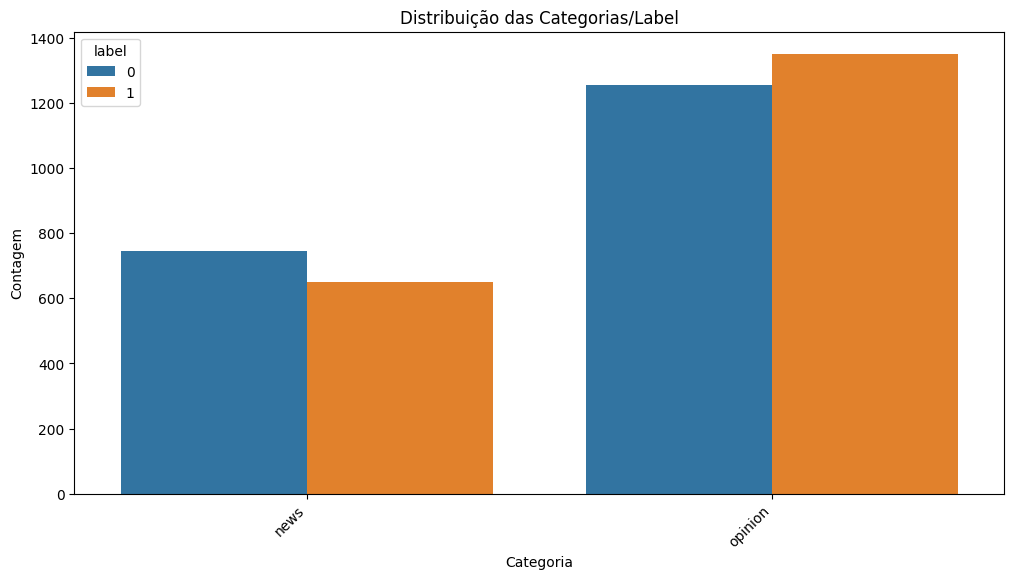

In [34]:
# Example usage:
num_instances_per_label = 2000  # Choose the desired number of instances
balanced_df = criar_dataframe_balanceado(df, num_instances_per_label)
max_tokens,min_cont,max_cont = analisar_dataframe(balanced_df,column_name='content')

Preparação dos Dados

(1) Coluna News ou Opiniao
(2) Coluna Categoria
(3) Coluna label


In [36]:
print("Número de palavras únicas:", max_tokens)
print("Minimo comprimento do conteúdo:", min_cont)
print("Máximo comprimento do conteúdo:", max_cont)

Número de palavras únicas: 43794
Minimo comprimento do conteúdo: 41
Máximo comprimento do conteúdo: 32765


Number of rows with label 0: 2000
Number of rows with label 1: 2000


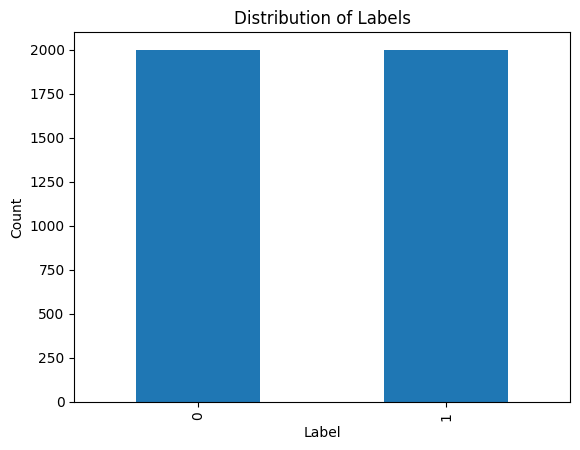

Minimum content length: 41
Maximum content length: 32765
Number of unique words: 43794


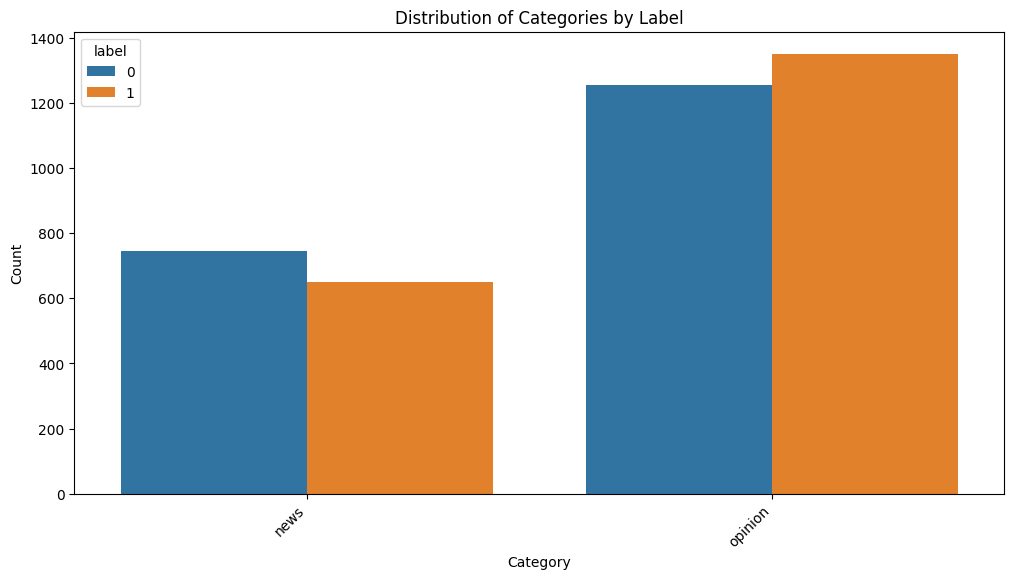

In [ ]:
analyze_dataframe(balanced_df,column_name='content')  # Call the function to analyze your DataFrame


SVM e Regressão Logística - Preparação dos Dados

In [56]:
# SVM and Logistic Regression - Preparação dos Dados
balanced_df['content'] = balanced_df['content'].apply(preprocess_text)
X_content = balanced_df['content'].values
X_category = balanced_df['category'].values
y = balanced_df['label'].values

# 1. Feature Extraction:
# Combine TF-IDF and Label Encoding in a Pipeline

preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(max_features=5000), 'content'),
        ('label_encoder', LabelEncoder(), ['category']),  # Encode 'category' column
    ],
    remainder='drop'  # Drop other columns
)

# 2. Create Pipelines for Logistic Regression and SVM
pipeline_logreg = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression()),
])

pipeline_svm = Pipeline([
    ('preprocessor', preprocessor),
    ('svm', SVC()),
])

# 3. Define Hyperparameter Grids
logreg_param_grid = {
    'preprocessor__tfidf__max_features': [5000, 7500, 10000],
    'logreg__C': [0.1, 1, 10],
    'logreg__penalty': ['l1', 'l2'],
    'logreg__solver': ['liblinear', 'saga']
}

svm_param_grid = {
    'preprocessor__tfidf__max_features': [5000, 7500, 10000],
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': ['scale', 'auto']
}

# 4. Perform Grid Search and Model Training
logreg_grid_search = GridSearchCV(pipeline_logreg, logreg_param_grid, cv=5, scoring='accuracy', verbose=2)
logreg_grid_search.fit(balanced_df, y)  # Fit on the original DataFrame

svm_grid_search = GridSearchCV(pipeline_svm, svm_param_grid, cv=5, scoring='accuracy', verbose=2)
svm_grid_search.fit(balanced_df, y)  # Fit on the original DataFrame


# 5. Evaluation and Results
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(balanced_df, y, test_size=0.2, random_state=42)

# Evaluate Logistic Regression
logreg_best_model = logreg_grid_search.best_estimator_
logreg_predictions = logreg_best_model.predict(X_test)
logreg_accuracy = accuracy_score(y_test, logreg_predictions)
print(f"Logistic Regression Accuracy (with tuning): {logreg_accuracy}")
print(classification_report(y_test, logreg_predictions))

# Evaluate SVM
svm_best_model = svm_grid_search.best_estimator_
svm_predictions = svm_best_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print(f"SVM Accuracy (with tuning): {svm_accuracy}")
print(classification_report(y_test, svm_predictions))

# Plot accuracies
import matplotlib.pyplot as plt

models = ['Logistic Regression', 'SVM']
accuracies = [logreg_accuracy, svm_accuracy]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['blue', 'green'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim([0, 1])  # Set y-axis limits for better visualization
plt.xticks(rotation)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END logreg__C=0.1, logreg__penalty=l1, logreg__solver=liblinear, preprocessor__tfidf__max_features=5000; total time=   1.1s
[CV] END logreg__C=0.1, logreg__penalty=l1, logreg__solver=liblinear, preprocessor__tfidf__max_features=5000; total time=   1.1s
[CV] END logreg__C=0.1, logreg__penalty=l1, logreg__solver=liblinear, preprocessor__tfidf__max_features=5000; total time=   1.1s
[CV] END logreg__C=0.1, logreg__penalty=l1, logreg__solver=liblinear, preprocessor__tfidf__max_features=5000; total time=   1.1s
[CV] END logreg__C=0.1, logreg__penalty=l1, logreg__solver=liblinear, preprocessor__tfidf__max_features=5000; total time=   1.1s
[CV] END logreg__C=0.1, logreg__penalty=l1, logreg__solver=liblinear, preprocessor__tfidf__max_features=7500; total time=   1.6s
[CV] END logreg__C=0.1, logreg__penalty=l1, logreg__solver=liblinear, preprocessor__tfidf__max_features=7500; total time=   1.9s
[CV] END logreg__C=0.1, logreg__pen

KeyboardInterrupt: 